In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [149]:
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')
customers = pd.read_csv('Customers.csv')

In [150]:
#I am not checking for null types or missing values and such as i checked for all those things in EDA part of Assignments
dataset = transactions.merge(products,on = "ProductID",how = 'left').merge(customers,on = "CustomerID",how = 'left')
dataset['TransactionDate'] = pd.to_datetime(dataset['TransactionDate'])
dataset['SignupDate'] = pd.to_datetime(dataset['SignupDate'])
dataset = dataset.drop(columns='Price_y',axis=1)
dataset.rename(columns={'Price_x':'Price'},inplace=True)
print(dataset)

    TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0          T00001      C0199      P067 2024-08-25 12:38:23         1   
1          T00112      C0146      P067 2024-05-27 22:23:54         1   
2          T00166      C0127      P067 2024-04-25 07:38:55         1   
3          T00272      C0087      P067 2024-03-26 22:55:37         2   
4          T00363      C0070      P067 2024-03-21 15:10:10         3   
..            ...        ...       ...                 ...       ...   
995        T00496      C0118      P037 2024-10-24 08:30:27         1   
996        T00759      C0059      P037 2024-06-04 02:15:24         3   
997        T00922      C0018      P037 2024-04-05 13:05:32         4   
998        T00959      C0115      P037 2024-09-29 10:16:02         2   
999        T00992      C0024      P037 2024-04-21 10:52:24         1   

     TotalValue   Price                      ProductName     Category  \
0        300.68  300.68  ComfortLiving Bluetooth Speaker  Elec

In [151]:
dataset.describe()

,TransactionDate,Quantity,TotalValue,Price,SignupDate
count,1000,1000.000000,1000.000000,1000.00000,1000
mean,2024-06-23 15:33:02.768999936,2.537000,689.995560,272.55407,2023-07-09 02:49:55.199999744
min,2023-12-30 15:29:12,1.000000,16.080000,16.08000,2022-01-22 00:00:00
25%,2024-03-25 22:05:34.500000,2.000000,295.295000,147.95000,2022-09-17 12:00:00
50%,2024-06-26 17:21:52.500000,3.000000,588.880000,299.93000,2023-07-23 00:00:00
75%,2024-09-19 14:19:57,4.000000,1011.660000,404.40000,2024-04-12 00:00:00
max,2024-12-28 11:00:00,4.000000,1991.040000,497.76000,2024-12-28 00:00:00
std,NaN,1.117981,493.144478,140.73639,NaN


In [152]:
regions_encoded = pd.get_dummies(dataset[['CustomerID','Region']], columns=['Region'])
print(regions_encoded.columns)

Index(['CustomerID', 'Region_Asia', 'Region_Europe', 'Region_North America',
       'Region_South America'],
      dtype='object')


In [153]:
customer_aggregates = dataset.groupby('CustomerID').agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalQuantity=('Quantity', 'sum'),
    TotalValue=('TotalValue', 'sum'),
    AvgSpendingPerTransaction = ('TotalValue', lambda x: x.sum() / x.count())
).reset_index()
print(customer_aggregates)

    CustomerID  TotalTransactions  TotalQuantity  TotalValue  \
0        C0001                  5             12     3354.52   
1        C0002                  4             10     1862.74   
2        C0003                  4             14     2725.38   
3        C0004                  8             23     5354.88   
4        C0005                  3              7     2034.24   
..         ...                ...            ...         ...   
194      C0196                  4             12     4982.88   
195      C0197                  3              9     1928.65   
196      C0198                  2              3      931.83   
197      C0199                  4              9     1979.28   
198      C0200                  5             16     4758.60   

     AvgSpendingPerTransaction  
0                   670.904000  
1                   465.685000  
2                   681.345000  
3                   669.360000  
4                   678.080000  
..                         ...  


In [154]:
customer_features = customer_aggregates.merge(regions_encoded,on='CustomerID',how='left')
customer_features = customer_features.drop_duplicates(subset='CustomerID').reset_index()
customer_features = customer_features.drop(columns='index',axis=1)
print(customer_features)

    CustomerID  TotalTransactions  TotalQuantity  TotalValue  \
0        C0001                  5             12     3354.52   
1        C0002                  4             10     1862.74   
2        C0003                  4             14     2725.38   
3        C0004                  8             23     5354.88   
4        C0005                  3              7     2034.24   
..         ...                ...            ...         ...   
194      C0196                  4             12     4982.88   
195      C0197                  3              9     1928.65   
196      C0198                  2              3      931.83   
197      C0199                  4              9     1979.28   
198      C0200                  5             16     4758.60   

     AvgSpendingPerTransaction  Region_Asia  Region_Europe  \
0                   670.904000        False          False   
1                   465.685000         True          False   
2                   681.345000        False  

In [155]:
import datetime
last_purchase_customers = dataset.groupby('CustomerID')['TransactionDate'].max().reset_index()
days_since_last_purchase = datetime.datetime.now() - last_purchase_customers['TransactionDate']
customer_features['DaysSinceLastPurchase'] = days_since_last_purchase.dt.days
print(customer_features['DaysSinceLastPurchase'])

0       82
1       52
2      152
3       32
4       81
      ... 
194     40
195     27
196    111
197     90
198     44
Name: DaysSinceLastPurchase, Length: 199, dtype: int64


In [156]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
customer_features['TotalValue'] = scaler.fit_transform(customer_features[['TotalValue']])
customer_features['DaysSinceLastPurchase'] = scaler.fit_transform(customer_features[['DaysSinceLastPurchase']])
customer_features['TotalTransactions'] = scaler.fit_transform(customer_features[['TotalTransactions']])
customer_features['TotalQuantity'] = scaler.fit_transform(customer_features[['TotalQuantity']])
customer_features['AvgSpendingPerTransaction'] = scaler.fit_transform(customer_features[['AvgSpendingPerTransaction']])

print(customer_features)

    CustomerID  TotalTransactions  TotalQuantity  TotalValue  \
0        C0001                0.4       0.354839    0.308942   
1        C0002                0.3       0.290323    0.168095   
2        C0003                0.3       0.419355    0.249541   
3        C0004                0.7       0.709677    0.497806   
4        C0005                0.2       0.193548    0.184287   
..         ...                ...            ...         ...   
194      C0196                0.3       0.354839    0.462684   
195      C0197                0.2       0.258065    0.174318   
196      C0198                0.1       0.064516    0.080203   
197      C0199                0.3       0.258065    0.179098   
198      C0200                0.4       0.483871    0.441508   

     AvgSpendingPerTransaction  Region_Asia  Region_Europe  \
0                     0.474336        False          False   
1                     0.308940         True          False   
2                     0.482751        False  

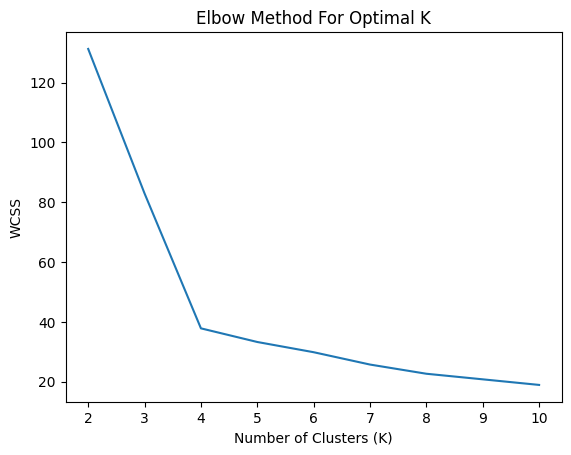

In [157]:
from sklearn.cluster import KMeans
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(customer_features.drop(columns=['CustomerID']))
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

 init=k-means++, max_iter=80, n_init=3, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=80, n_init=4, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=80, n_init=5, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=80, n_init=6, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=80, n_init=7, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=80, n_init=8, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=90, n_init=3, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=90, n_init=4, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=90, n_init=5, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=90, n_init=6, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=90, n_init=7, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=90, n_init=8, Silhouette Score=0.6983452304994472
 init=k-means++, max_iter=100, n_init=3, Silhouette Score=0.6983452304994472
 init=k-mea

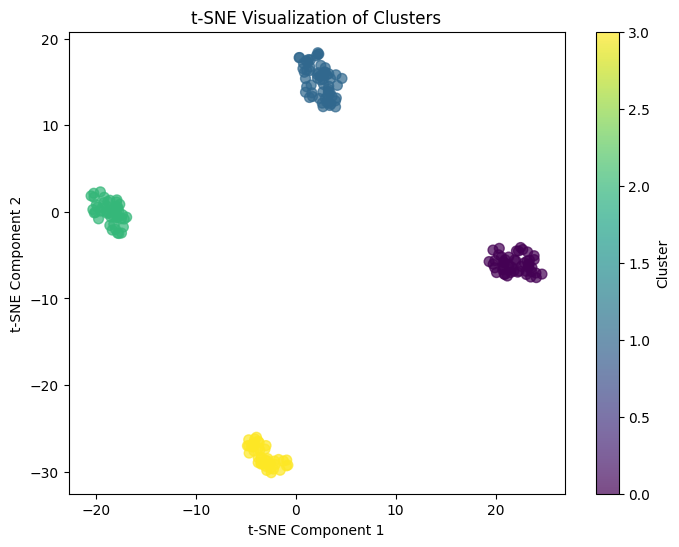

In [162]:
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.manifold import TSNE

param_grid = {
    'init': ['k-means++', 'random'],
    'max_iter': [80,90,100,110,120],
    'n_init': [3,4,5,6,7,8]
}

best_score = -1
best_params = {}
best_kmeans = None

X = customer_features.drop(columns=['CustomerID'])

for init in param_grid['init']:
    for max_iter in param_grid['max_iter']:
        for n_init in param_grid['n_init']:


            kmeans = KMeans(n_clusters=4, init=init, max_iter=max_iter, n_init=n_init, random_state=42)
            kmeans.fit(X)

            silhouette_avg = silhouette_score(X, kmeans.labels_)
            print(f" init={init}, max_iter={max_iter}, n_init={n_init}, Silhouette Score={silhouette_avg}")
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = {'init': init, 'max_iter': max_iter, 'n_init': n_init}
                best_kmeans = kmeans

print(f"Best Hyperparameters: {best_params}")
print(f"Best Silhouette Score: {best_score}")
db_index = davies_bouldin_score(X, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")

customer_features['Cluster'] = best_kmeans.labels_

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_components = tsne.fit_transform(X)

tsne_df = pd.DataFrame(tsne_components, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = customer_features['Cluster']

plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.title('t-SNE Visualization of Clusters')
plt.show()


In [161]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_components = tsne.fit_transform(X)

tsne_df = pd.DataFrame(tsne_components, columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_df['Cluster'] = customer_features['Cluster']


import plotly.express as px

fig = px.scatter_3d(
    tsne_df,
    x='TSNE1',
    y='TSNE2',
    z='TSNE3',
    color='Cluster',
    color_continuous_scale='Viridis',
    title='3D t-SNE Visualization of Clusters'
)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.show()
fig.write_html("3d_tsne_plot.html")